In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib2tikz as mpl2t

/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/matplotlib2tikz/__init__.py:31: UserWarning: matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.
  warnings.warn("matplotlib2tikz has been renamed to tikzplotlib (which is Python-3-only). matplotlib2tikz will no longer be supported.")


### Per-index errors

/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/matplotlib2tikz/axes.py:508: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  major_ticks_bottom = [tick.tick1On for tick in major_ticks]
/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/matplotlib2tikz/axes.py:509: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.get_visible instead.
  major_ticks_top = [tick.tick2On for tick in major_ticks]


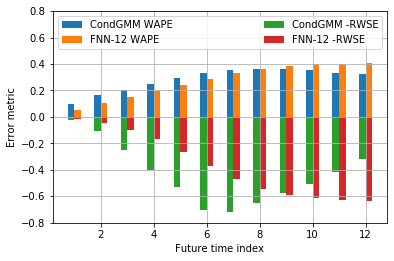

In [2]:
cgmmwape = np.array([0.0967, 0.1663, 0.2062, 0.2494, 0.2934, 0.3296, 0.3531, 0.3637, 0.3646,
        0.3544, 0.3356, 0.3224])
cgmmrwse = np.array([0.0227, 0.1085, 0.2472, 0.4007, 0.5269, 0.7024, 0.7149, 0.6522, 0.5754,
        0.5092, 0.4189, 0.3190])
fnnwape = np.array([0.0524, 0.1024, 0.1486, 0.1937, 0.2403, 0.2873, 0.3317, 0.3645, 0.3851,
        0.3965, 0.4025, 0.4062])
fnnrwse = np.array([0.0119, 0.0465, 0.0975, 0.1674, 0.2639, 0.3735, 0.4721, 0.5437, 0.5895,
        0.6148, 0.6265, 0.6335])

x = np.arange(1,13)
width = 0.25
gap = .04
fig, ax = plt.subplots()
cw = ax.bar(x - width/2, cgmmwape, width, label='CondGMM WAPE')
fw = ax.bar(x + width/2, fnnwape, width, label='FNN-12 WAPE')
cr = ax.bar(x - width/2, -cgmmrwse, width, label='CondGMM -RWSE')
fr = ax.bar(x + width/2, -fnnrwse, width, label='FNN-12 -RWSE')
ax.set_ylim([-0.8, 0.8])
ax.legend(mode='expand', ncol=2)
ax.set_aspect(5)
plt.xlabel('Future time index')
plt.ylabel('Error metric')
plt.grid(True)
mpl2t.save('errors.tex')

### Samples (2B)

In [1]:
import os
import sys

import torch
import torch.nn as nn

sys.path.append("../../../")
import CalibratedTimeseriesModels

from CalibratedTimeseriesModels.utils import *
from CalibratedTimeseriesModels.models.cgmm import *
from CalibratedTimeseriesModels.models.gmnn import *
from CalibratedTimeseriesModels.models.blr import *

%load_ext autoreload
%autoreload 2

In [3]:
# load data
from load_data import load_data
X_train, Y_train_full, X_test, Y_test_full = load_data(9, 8, 12)
Y_train = Y_train_full[:,[0],:]
Y_test = Y_test_full[:,[0],:]

X_batches, Y_batches = batch(X_train, Y_train, batch_size = 128)

In [5]:
#rnn12
hidden_layers = [20, 20, 20]
hidden_dim = 40
rnn12 = GaussianMixtureLSTM(1, hidden_dim, hidden_layers, 1, 1, 
                                 n_components=3, random_state=0)
train(rnn12, X_batches, Y_batches, num_epochs=200, learning_rate=.005)
dtest_rnn12 = rnn12(X_test)
samples_rnn12 = sample_forward_lstm(rnn12, X_test, fut_dims, n_samples=25)

epoch : 1, loss: 0.7227
epoch : 11, loss: -1.2463
epoch : 21, loss: -1.5367
epoch : 31, loss: -1.7703
epoch : 41, loss: -1.8124
epoch : 51, loss: -1.9627
epoch : 61, loss: -2.1091
epoch : 71, loss: -2.1603
epoch : 81, loss: -2.2543
epoch : 91, loss: -2.2125
epoch : 101, loss: -2.3271
epoch : 111, loss: -2.3301
epoch : 121, loss: -2.3858
epoch : 131, loss: -2.4040
epoch : 141, loss: -2.3724
epoch : 151, loss: -2.4718
epoch : 161, loss: -2.4356
epoch : 171, loss: -2.5083
epoch : 181, loss: -2.5332
epoch : 191, loss: -2.6067
Learning finished!


In [6]:
#cgmm
cgmm = ConditionalGMM(1, past_dims, 1, fut_dims, 
                      n_components=5, random_state=4)
cgmm.fit(X_train, Y_train_full)
dtest_cgmm = cgmm(X_test)
samples_cgmm = dtest_cgmm.sample((25,))

/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/matplotlib2tikz/axes.py:508: MatplotlibDeprecationWarning: 
The tick1On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick1line.get_visible instead.
  major_ticks_bottom = [tick.tick1On for tick in major_ticks]
/home/arec/miniconda3/envs/ctm/lib/python3.7/site-packages/matplotlib2tikz/axes.py:509: MatplotlibDeprecationWarning: 
The tick2On function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use Tick.tick2line.get_visible instead.
  major_ticks_top = [tick.tick2On for tick in major_ticks]


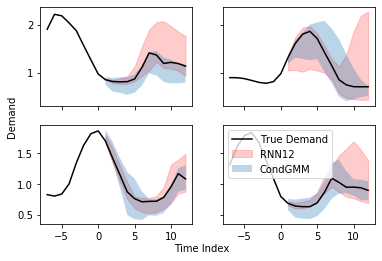

In [52]:
idxs = [100, 200, 300, 400]
fig, axs = plt.subplots(2,2, sharex='col', sharey='row')

for i in range(len(idxs)):
    r = i // 2
    c = i % 2
    axs[r,c].plot(range(-past_dims+1,fut_dims+1),
                torch.cat((X_test[idxs[i],:,0],
                           Y_test_full[idxs[i],:,0]),0), 
                color='k', label='True Demand')
    cgmm_lower = torch.min(samples_cgmm[:,idxs[i],:],dim=0)[0].squeeze()
    cgmm_upper = torch.max(samples_cgmm[:,idxs[i],:],dim=0)[0].squeeze()
    rnn12_lower = torch.min(samples_rnn12[:,idxs[i],:],dim=0)[0].squeeze()
    rnn12_upper = torch.max(samples_rnn12[:,idxs[i],:],dim=0)[0].squeeze()
    axs[r,c].fill_between(range(1,fut_dims+1),rnn12_lower, rnn12_upper,
                          color='r',alpha=0.2,
                        label='RNN12')
    axs[r,c].fill_between(range(1,fut_dims+1),cgmm_lower, 
                        cgmm_upper,alpha=0.3,
                        label='CondGMM')

fig.text(0.5, 0.04, 'Time Index', ha='center', va='center')
fig.text(0.06, 0.5, 'Demand', ha='center', va='center', rotation='vertical')
handles, labels = axs[1,1].get_legend_handles_labels()
#fig.legend(handles, labels, loc='upper center',ncol=3)
axs[1,1].legend(loc='upper left')
mpl2t.save('samples.tex')